In [ ]:
!unzip "/content/Floating Waste.v10i.coco (1).zip" -d /content/floating_waste


Streaming output truncated to the last 5000 lines.
 extracting: /content/floating_waste/train/741_jpg.rf.fe717c7dd7d122f116a2cbbfb503dcd4.jpg  
 extracting: /content/floating_waste/train/742_jpg.rf.578d7ba8770292c5e43715b18ac12328.jpg  
 extracting: /content/floating_waste/train/742_jpg.rf.68d9efa85b384cf0aa3cb261fcff97b0.jpg  
 extracting: /content/floating_waste/train/742_jpg.rf.dd591556823b3f569d32e705620bddbd.jpg  
 extracting: /content/floating_waste/train/743_jpg.rf.232e3bcf44ad62bbef55f2df385ad487.jpg  
 extracting: /content/floating_waste/train/743_jpg.rf.48d6dc921fd94124ad7496003f4e372b.jpg  
 extracting: /content/floating_waste/train/743_jpg.rf.8fccbc093041282cf6d6c81596d6323f.jpg  
 extracting: /content/floating_waste/train/744_jpg.rf.02018e6c7477536b681ecb9d5a3d5e3c.jpg  
 extracting: /content/floating_waste/train/744_jpg.rf.73a2d6905f9e41cfafee24941133924f.jpg  
 extracting: /content/floating_waste/train/744_jpg.rf.f29105da58197dbc2533fa202ea73cd5.jpg  
 extracting: /conte

In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from PIL import Image
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# COCO-style dataset loader
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_path):
        self.image_dir = image_dir
        with open(annotation_path, 'r') as f:
            coco = json.load(f)

        self.images = {img['id']: img['file_name'] for img in coco['images']}
        self.annotations = {}
        for ann in coco['annotations']:
            img_id = ann['image_id']
            bbox = ann['bbox']  # [x, y, width, height]
            label = ann['category_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append({"bbox": bbox, "label": label})

        # Filter only existing images
        self.ids = [img_id for img_id in self.images if os.path.exists(os.path.join(self.image_dir, self.images[img_id]))]
        missing = set(self.images.keys()) - set(self.ids)
        if missing:
            print(f"[Warning] {len(missing)} images referenced in annotations not found in '{self.image_dir}' and will be skipped.")

        self.class_to_idx = {cat['id']: cat['name'] for cat in coco['categories']}

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.image_dir, self.images[img_id])

        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            return None

        annots = self.annotations.get(img_id, [])
        boxes = []
        labels = []
        for ann in annots:
            x, y, w, h = ann['bbox']
            boxes.append(torch.tensor([x, y, x + w, y + h], dtype=torch.float32))
            labels.append(ann['label'])

        if not boxes:
            return None

        target = {
            "boxes": torch.stack(boxes),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        return F.to_tensor(img), target

# Collate function
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return tuple(zip(*batch)) if batch else ([], [])

# Dataset paths
image_dir = "/content/floating_waste/train"
annotation_file = "/content/floating_waste/train/_annotations.coco.json"

# Load dataset
train_dataset = COCODataset(image_dir, annotation_file)
if len(train_dataset) == 0:
    raise ValueError("No valid training samples found. Please verify your dataset paths and annotations.")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Load model (MobileNet backbone for smaller & faster model)
model = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")

# Replace the head
num_classes = len(set(train_dataset.class_to_idx.keys())) + 1  # background + classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer & scaler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = torch.amp.GradScaler(device="cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    loop = tqdm(train_loader, desc="Training", unit="batch")

    for i, batch in enumerate(loop):
        if not batch[0]:
            continue

        images, targets = batch
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_loss = losses.item()
        running_loss += batch_loss

        loop.set_postfix(batch_loss=batch_loss)

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

print("\nTraining complete.")


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 150MB/s]



Epoch [1/10]


Training: 100%|██████████| 1672/1672 [04:39<00:00,  5.98batch/s, batch_loss=0.206]


Epoch [1/10] Avg Loss: 0.3125

Epoch [2/10]


Training: 100%|██████████| 1672/1672 [04:29<00:00,  6.20batch/s, batch_loss=0.281]


Epoch [2/10] Avg Loss: 0.3408

Epoch [3/10]


Training: 100%|██████████| 1672/1672 [04:26<00:00,  6.28batch/s, batch_loss=0.219]


Epoch [3/10] Avg Loss: 0.3548

Epoch [4/10]


Training: 100%|██████████| 1672/1672 [04:25<00:00,  6.29batch/s, batch_loss=0.51]


Epoch [4/10] Avg Loss: 0.3655

Epoch [5/10]


Training: 100%|██████████| 1672/1672 [04:24<00:00,  6.32batch/s, batch_loss=0.537]


Epoch [5/10] Avg Loss: 0.3767

Epoch [6/10]


Training: 100%|██████████| 1672/1672 [04:23<00:00,  6.35batch/s, batch_loss=0.454]


Epoch [6/10] Avg Loss: 0.3774

Epoch [7/10]


Training: 100%|██████████| 1672/1672 [04:24<00:00,  6.33batch/s, batch_loss=0.258]


Epoch [7/10] Avg Loss: 0.3758

Epoch [8/10]


Training: 100%|██████████| 1672/1672 [04:24<00:00,  6.33batch/s, batch_loss=0.25]


Epoch [8/10] Avg Loss: 0.3836

Epoch [9/10]


Training: 100%|██████████| 1672/1672 [04:24<00:00,  6.32batch/s, batch_loss=0.165]


Epoch [9/10] Avg Loss: 0.3798

Epoch [10/10]


Training: 100%|██████████| 1672/1672 [04:24<00:00,  6.33batch/s, batch_loss=0.12]

Epoch [10/10] Avg Loss: 0.3776

Training complete.


In [ ]:
import json

# Path to your COCO annotation file
annotation_path = "/content/floating_waste/train/_annotations.coco.json"

# Load the category names from the COCO JSON
with open(annotation_path) as f:
    coco_json = json.load(f)
    classes = coco_json['categories']  # This is a list of dicts like: [{'id': 1, 'name': 'bottle'}, ...]


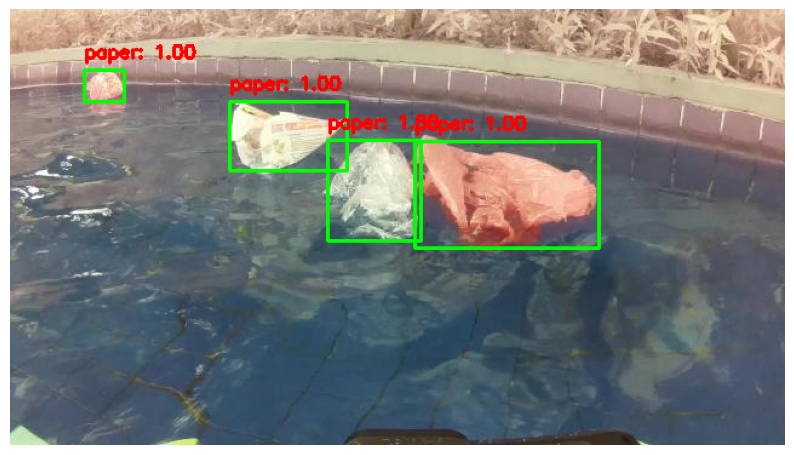

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T

def predict_image(image_path, model, classes, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).to(device)

    with torch.no_grad():
        prediction = model([img_tensor])[0]

    img_np = np.array(image)

    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = box.int().cpu().numpy()
            class_name = classes[label.item() - 1]['name']
            img_np = cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            img_np = cv2.putText(img_np, f"{class_name}: {score:.2f}", (x1, y1-10),
                                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_np)
    plt.axis("off")
    plt.show()

# Example usage
predict_image("/content/floating_waste/valid/frame_000429_jpg.rf.63f26366e51722f747603d893898b0e3.jpg", model, classes)

In [ ]:
torch.save(model.state_dict(), "fasterrcnn_floating_trash_new1.pth")

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision import transforms
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from tqdm import tqdm

# ------------------
# Paths
# ------------------
VAL_IMAGES_DIR = "/content/floating_waste/valid"
VAL_ANN_FILE = "/content/floating_waste/valid/_annotations.coco.json"
MODEL_PATH = "/content/fasterrcnn_floating_trash_new1.pth"  # your checkpoint
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------
# Auto-detect number of classes from COCO JSON
# ------------------
with open(VAL_ANN_FILE, "r") as f:
    coco_json = json.load(f)
NUM_CLASSES = len(coco_json["categories"]) + 1  # +1 for background
print(f"Detected {NUM_CLASSES - 1} classes + background")

# ------------------
# Dataset & Loader
# ------------------
transform = transforms.Compose([transforms.ToTensor()])
dataset = CocoDetection(root=VAL_IMAGES_DIR, annFile=VAL_ANN_FILE, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False,
                                          collate_fn=lambda x: tuple(zip(*x)))

# ------------------
# Rebuild Model Architecture
# ------------------
print("Loading model checkpoint...")
model = fasterrcnn_mobilenet_v3_large_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
print("Model loaded.")

# ------------------
# Run Inference
# ------------------
print("Running inference...")
results = []

with torch.no_grad():
    for idx, (images, targets) in enumerate(tqdm(data_loader)):
        images = [img.to(DEVICE) for img in images]
        outputs = model(images)

        for target, out in zip(targets, outputs):
            if len(target) > 0:
                image_id = int(target[0]["image_id"])
            else:
                image_id = int(dataset.ids[idx])

            boxes  = out["boxes"].cpu().numpy()
            scores = out["scores"].cpu().numpy()
            labels = out["labels"].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [
                        float(x_min),
                        float(y_min),
                        float(x_max - x_min),
                        float(y_max - y_min)
                    ],
                    "score": float(score)
                })

# ------------------
# Save Predictions to JSON
# ------------------
results_file = "coco_results.json"
with open(results_file, "w") as f:
    json.dump(results, f)

# ------------------
# Evaluate with COCO API
# ------------------
print("Evaluating...")
coco_gt = COCO(VAL_ANN_FILE)
coco_dt = coco_gt.loadRes(results_file)

coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()





Detected 6 classes + background
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model checkpoint...
Model loaded.
Running inference...


100%|██████████| 638/638 [00:18<00:00, 34.39it/s]


Evaluating...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.77s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=  

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

trained_weights_path = "/content/fasterrcnn_floating_trash_new1.pth"
num_classes_new = 6  # 6 classes, no background in your label indexing

# Initialize model architecture without pretrained weights
model = fasterrcnn_mobilenet_v3_large_fpn(weights=None, weights_backbone=None)

# Load full checkpoint state dict
checkpoint = torch.load(trained_weights_path, map_location=torch.device('cpu'))

# Remove classification head params from checkpoint dict to avoid size mismatch
checkpoint_filtered = {k: v for k, v in checkpoint.items()
                       if not k.startswith("roi_heads.box_predictor.")}

# Load filtered checkpoint into model
model.load_state_dict(checkpoint_filtered, strict=False)

# Replace the box predictor with a new one for your number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes_new)

model.eval()

# Quantize dynamically
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear, torch.nn.Conv2d}, dtype=torch.qint8
)

# Convert to TorchScript
scripted_model = torch.jit.script(quantized_model)

# Save scripted model
scripted_model.save("scripted_quantized_mobilenet_frcnn_new1.pt")

print("MobileNetV3-FPN model loaded, old head removed, quantized, scripted, and saved successfully!")

MobileNetV3-FPN model loaded, old head removed, quantized, scripted, and saved successfully!


In [ ]:
import torch
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

# ------------------ Paths ------------------
MODEL_PATH = "/content/scripted_quantized_mobilenet_frcnn_new1.pt"
VAL_ANN_FILE = "/content/floating_waste/valid/_annotations.coco.json"
IMAGE_PATH = "/content/floating_waste/valid/frame_000429_jpg.rf.63f26366e51722f747603d893898b0e3.jpg"  # test image

# ------------------ Device ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ Load TorchScript model ------------------
print("Loading TorchScript model...")
model = torch.jit.load(MODEL_PATH, map_location=device)
model.eval()
model.to(device)
print("Model loaded.")

# ------------------ Load classes from COCO JSON ------------------
with open(VAL_ANN_FILE, "r") as f:
    coco_json = json.load(f)

# Map category id -> class name
classes = {cat["id"]: cat["name"] for cat in coco_json["categories"]}
print(f"Detected classes: {classes}")

# ------------------ Prediction & Visualization Function ------------------
def predict_image(image_path, model, classes, threshold=0.5):
    # Load image
    image = Image.open(image_path).convert("RGB")
    img_tensor = T.ToTensor()(image).to(device)

    # Run inference
    with torch.no_grad():
        output = model([img_tensor])
        # TorchScript Faster R-CNN may return tuple: (losses, detections)
        if isinstance(output, tuple) and len(output) == 2:
            _, prediction = output
            prediction = prediction[0]
        else:
            prediction = output[0]

    # Convert to NumPy for visualization
    img_np = np.array(image)

    # Draw boxes and labels
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = box.int().cpu().numpy()
            class_name = classes[label.item()]
            img_np = cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            img_np = cv2.putText(img_np, f"{class_name}: {score:.2f}", (x1, y1-10),
                                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display image
    plt.figure(figsize=(12, 10))
    plt.imshow(img_np)
    plt.axis("off")
    plt.show()

# ------------------ Run on Example Image ------------------
predict_image(IMAGE_PATH, model, classes, threshold=0.5)


In [ ]:
import torch
from PIL import Image
from torchvision.transforms import functional as F

# Load the scripted quantized model
model = torch.jit.load("scripted_quantized_mobilenet_frcnn_new1.pt")
model.eval()

# Load an image
image_path = "path_to_your_image.jpg"
img = Image.open(image_path).convert("RGB")
img_tensor = F.to_tensor(img)  # Convert to [C, H, W] tensor

# Forward pass (wrap in list as model expects a batch)
with torch.no_grad():
    outputs = model([img_tensor])

# outputs is a list of dicts (one per image)
for i, output in enumerate(outputs):
    print(f"\nImage {i+1} predictions:")
    boxes = output["boxes"]
    labels = output["labels"]
    scores = output["scores"]

    for j in range(len(boxes)):
        print(f"Object {j+1}:")
        print(f"  Box: {boxes[j].tolist()}")
        print(f"  Label: {labels[j].item()}")
        print(f"  Score: {scores[j].item():.4f}")
